<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#IOR-vendor-comparison" data-toc-modified-id="IOR-vendor-comparison-1">IOR vendor comparison</a></span></li><li><span><a href="#Metadata-vendor-comparison" data-toc-modified-id="Metadata-vendor-comparison-2">Metadata vendor comparison</a></span></li></ul></div>

In [1]:
# Init code 
import re
import pandas as pd
import matplotlib.pyplot as plt

import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 1000
mpl.rcParams['font.family'] = "Arial"

def GiB_to_Gb(val):
    return val*8*1024**3/10**9

def Gb_to_GiB(val):
    return val*10**9/(8*1024**3)

def label_axes(ax, vendor, ylabel):
    nodes_and_threads = results_summary.loc[:, :, vendor].index.values
    xlabels = [f'{n}-N\n{t}-T' for n, t in nodes_and_threads]
    ax.set_xticklabels(xlabels, rotation=0)
    ax.set_xlabel('Nodes (N) & Tasks-per-node (T)')
    ax.set_ylabel(ylabel)
    if 'GiB/s' in ylabel:
        ax2 = ax.twinx()
        ax2.set_ylim(tuple(map(GiB_to_Gb, ax.get_ylim())))
        ax2.set_ylabel('Gb/s')
    return ax

def expand_col(df, idxs, cat_col, val_col):
    df = df.set_index(idxs)
    mask = pd.get_dummies(df[cat_col])
    result = mask.mul(df[val_col], axis=0).groupby(idxs).max()
    result.replace(0, np.nan, inplace=True)
    return result


# This just dumps all results into a csv

import pandas as pd
import glob, os
import read_summary

# Create a dataframe and units dict from any result summary files found:
pattern = './runs/*/result_summary.txt'
results, units = read_summary.df_from_pattern(pattern)
# print('Loaded %i result files.' % len(results))
# print('Columns/units:')
# print(units)
# print()
results.to_csv('all-results.csv')


# Read csv into pandas dataframe for analysis and plotting 
df = pd.read_csv('../../all-results.csv')
df.drop(['Unnamed: 0', 'stonewall', 'time'], axis=1, inplace=True)
df = df[df.ior_api == 'POSIX']
df.drop(['ior_api'], axis=1, inplace=True)

run_params = [
    'nodes',
    'ntasks_per_node',
    'filesystem.name',
#     'stonewall',
#     'time',
#     'ior_api',
#     'filesystem.mountpoint'
]

test_names = list(filter(
    lambda col: any(map(
        lambda x: x in col, ['mdtest-', 'ior-', 'score', 'find']
    )), df.columns
))

g = df.groupby(run_params)
results_summary = g[test_names].max()
results_summary.dropna(inplace=True)
nodes, threads, vendors = list(zip(*results_summary.index.values.tolist()))
results_summary

ior-easy-write  mdtest-easy-write  \
nodes ntasks_per_node filesystem.name                                      
1     1               panasas                1.184695           0.543807   
                      pure                   1.287587           1.178051   
                      quobyte                0.650807           0.279465   
      2               panasas                1.995671           1.031222   
                      pure                   1.313077           1.968212   
                      quobyte                1.357173           0.510967   
      4               panasas                2.894561           1.862027   
                      pure                   1.484341           4.146555   
                      quobyte                2.610983           0.996077   
      16              panasas                3.718167           3.949203   
                      pure                   1.676692          12.292754   
                      quobyte                1.359217           2.968402   
      32              panasas                3.449866           4.703268   
                      pure                   1.698081          14.681107   
                      quobyte                0.916172           2.346563   
2     1               panasas                2.207229           1.054290   
                      pure                   2.171984           2.118072   
      2               panasas                3.598561           1.843773   
                      pure                   2.525568           4.168694   
                      quobyte                0.957146           0.731785   
      16              panasas                7.310386           4.810563   
                      pure                   2.869526          25.132121   
                      quobyte                2.748111           3.510227   
10    2               panasas               15.230130           4.332634   
                      pure                   2.523238          19.517190   
      16              panasas               18.418785           5.787050   
                      pure                   0.818134          82.021362   

                                       ior-hard-write  mdtest-hard-write  \
nodes ntasks_per_node filesystem.name                                      
1     1               panasas                0.931208           0.270639   
                      pure                   1.362447           0.561116   
                      quobyte                0.444775           0.005946   
      2               panasas                0.051920           0.497684   
                      pure                   0.763956           1.173719   
                      quobyte                0.001541           0.010373   
      4               panasas                0.055406           0.536604   
                      pure                   0.319586           1.248566   
                      quobyte                0.001136           0.022176   
      16              panasas                0.061575           0.521377   
                      pure                   0.222805           1.178226   
                      quobyte                0.000839           0.114523   
      32              panasas                0.055081           0.507603   
                      pure                   0.204409           1.057013   
                      quobyte                0.000667           0.170412   
2     1               panasas                0.020932           0.537699   
                      pure                   0.426957           1.201452   
      2               panasas                0.020827           0.958952   
                      pure                   0.290374           2.021514   
                      quobyte                0.000574           0.021982   
      16              panasas                0.020769           1.021370   
                      pure                   0.289780           1.964184   
          

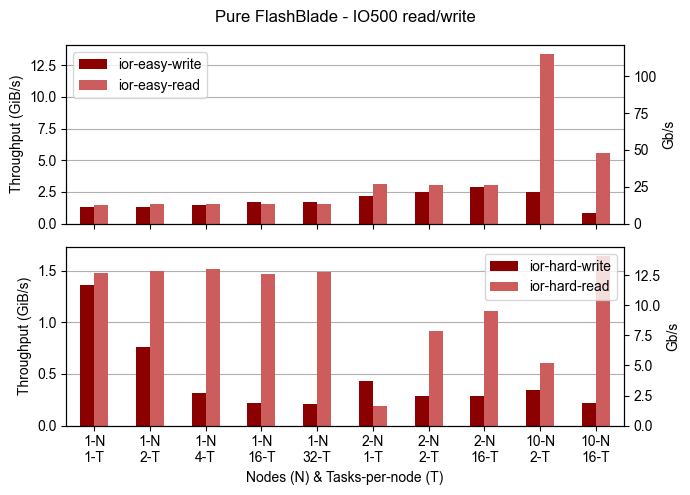

In [2]:
# Code 
def plot_rw_summary(vendor, colours=['darkred', 'indianred']):
    fig, axs = plt.subplots(figsize=(7, 5), ncols=1, nrows=2, sharex=True)
    for p, ax in zip(['ior-easy', 'ior-hard'], axs):
        results_summary.loc[:, :, vendor][
            [col for col in results_summary.columns if re.match(p, col)]
        ].plot.bar(
            ax=ax, 
            ylabel='GiB/s', 
            zorder=2,
            color=colours,
        )
        ax.yaxis.grid('y')
        label_axes(ax, vendor, 'Throughput (GiB/s)')

    fig.suptitle(f'{vendor.title()} storage - IO500 read/write')
    fig.tight_layout()
    return fig, axs

vendor = 'pure'
fig, axs = plot_rw_summary(vendor)
fig.suptitle('Pure FlashBlade - IO500 read/write')
fig.savefig(f'figures/io500-{vendor}-RW.png')

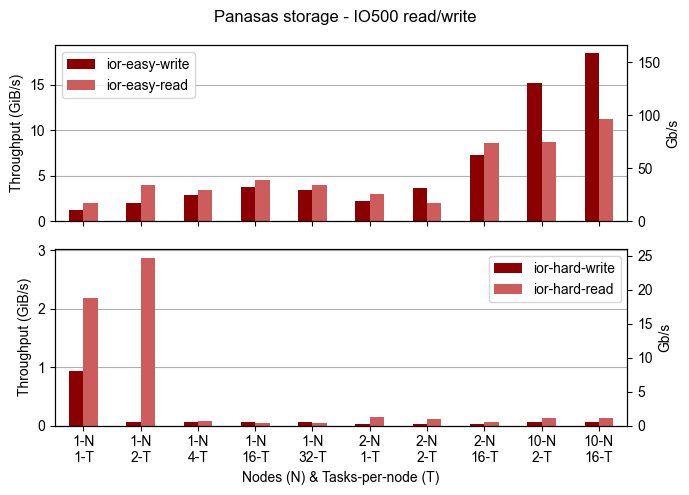

In [3]:
vendor = 'panasas'
fig, axs = plot_rw_summary(vendor)
fig.savefig(f'figures/io500-{vendor}-RW.png')

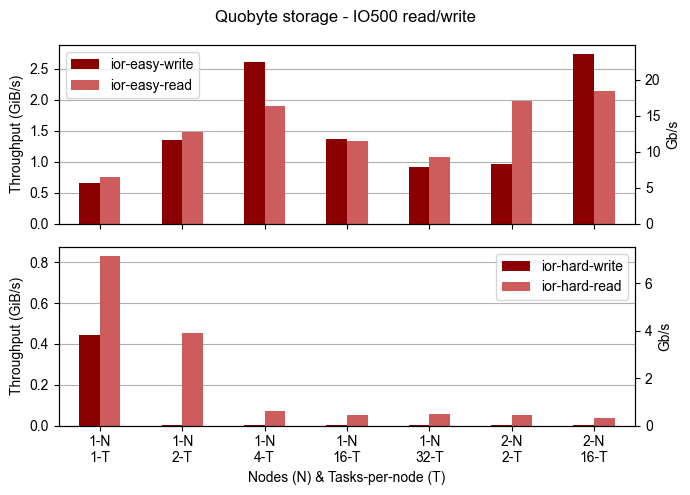

In [4]:
vendor = 'quobyte'
fig, axs = plot_rw_summary(vendor)
fig.savefig(f'figures/io500-{vendor}-RW.png')

Metadata plots:

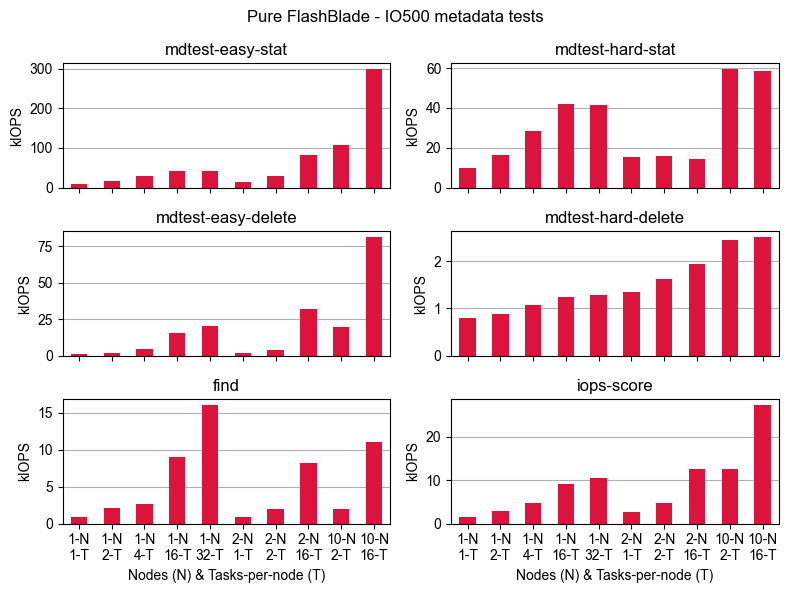

In [5]:
# Code 
def plot_single_vendor_md(vendor):
    tests = [
        'mdtest-easy-stat',
        'mdtest-hard-stat',
        'mdtest-easy-delete',
        'mdtest-hard-delete',
        'find',
        'iops-score'
    ]
    fig, axs = plt.subplots(
        figsize=(8, 6), 
        ncols=2, 
        nrows=len(tests)//2,
        sharex=True
    )

    for ax, test in zip(axs.flatten(), tests):
        results_summary.loc[:, :, vendor][test].plot.bar(ax=ax, zorder=2, color='crimson')
        label_axes(ax, vendor, 'kIOPS')
        ax.set_title(test, ) #y=0.83, x=0.02, ha='left')
        ax.grid(axis='y')
        
    fig.suptitle(f'{vendor.title()} storage - IO500 metadata tests')
    fig.tight_layout()

    return fig, axs

vendor = 'pure'
fig, axs = plot_single_vendor_md(vendor)
fig.suptitle('Pure FlashBlade - IO500 metadata tests')
fig.savefig(f'figures/io500-{vendor}-metadata.png')

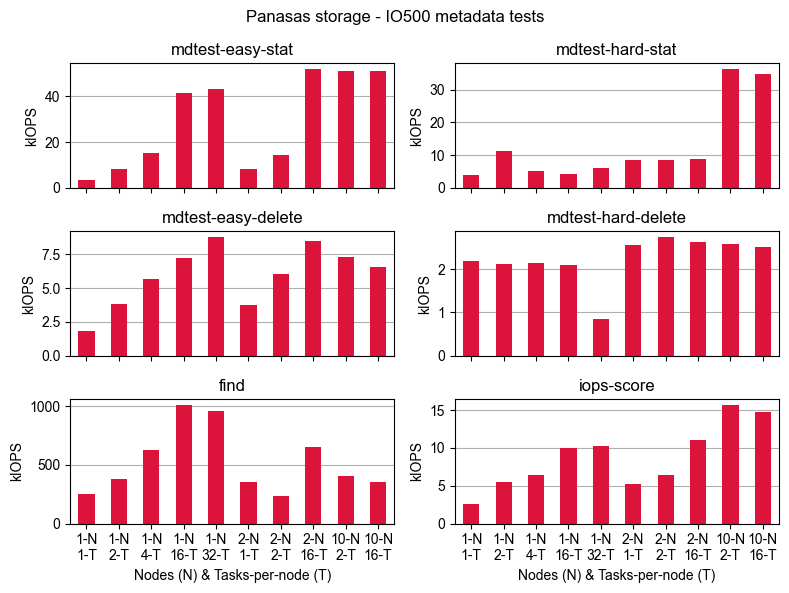

In [7]:
vendor = 'panasas'
fig, axs = plot_single_vendor_md(vendor)
ymin, ymax = axs[1, 0].get_ylim()
fig.savefig(f'figures/io500-{vendor}-metadata.png')

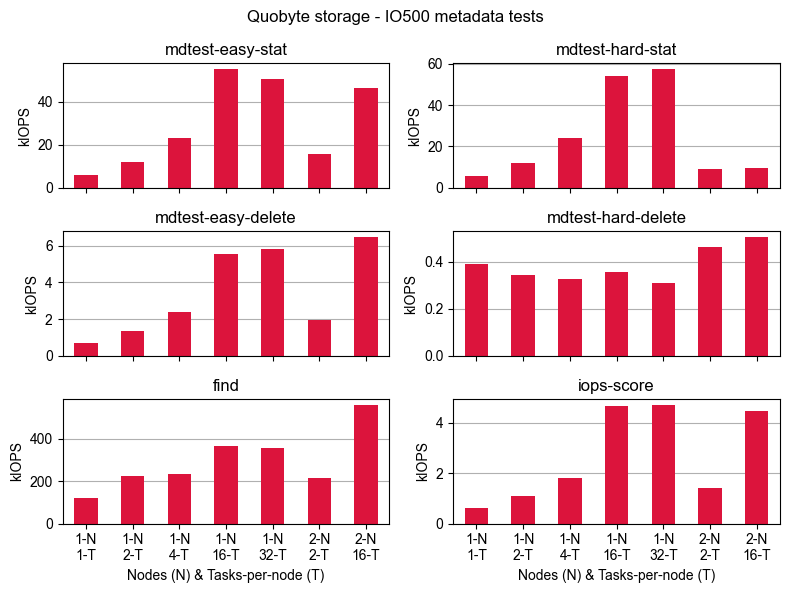

In [8]:
vendor = 'quobyte'
fig, axs = plot_single_vendor_md(vendor)
fig.savefig(f'figures/io500-{vendor}-metadata.png')

## IOR vendor comparison

,panasas,pure,quobyte
test-name,,,
ior-hard-read,0.059594,1.114669,0.035004
ior-hard-write,0.020769,0.289780,0.000317


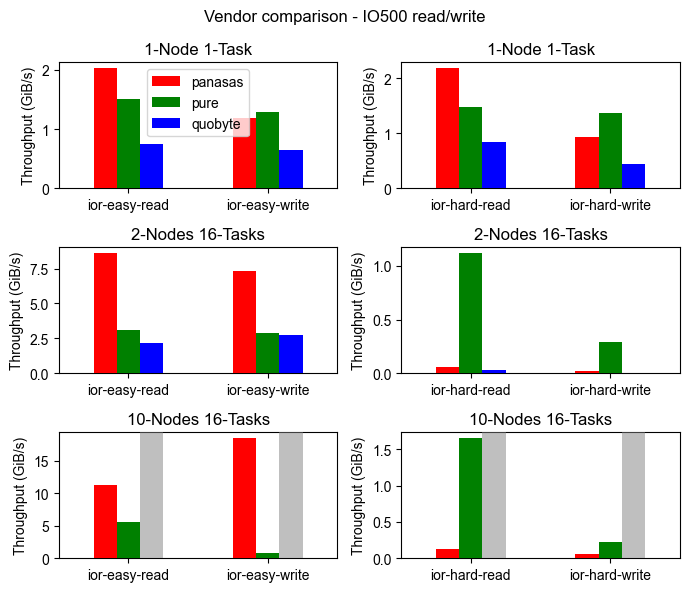

In [6]:
# Code 
def contract_cols(df, col_names):
    dfs = []
    df = df.copy().reset_index()
    for c in col_names:
        _df = pd.DataFrame({
            'test-name': [c for i in range(len(df))],
            'score': df[c].values,
            'nodes': df.nodes,
            'ntasks_per_node': df.ntasks_per_node,
            'filesystem.name': df['filesystem.name']
        })
        dfs.append(_df)
    
    return pd.concat(dfs)

def plot_vendor_rw_comparsion(results_data, tests):

    nodes_and_procs = [(1, 1), (2, 16), (10, 16)]
    fig, axs = plt.subplots(figsize=(7, 6), ncols=len(tests), nrows=len(nodes_and_procs))
    for i, t in enumerate(tests):
        for j, (n, p) in enumerate(nodes_and_procs): 

            ax = axs[j, i]

            # Wrangle data into correct format
            cols = [col for col in results_data.columns if t in col]
            data = contract_cols(results_data, cols)
            data = expand_col(data, ['nodes', 'ntasks_per_node', 'test-name'], 'filesystem.name', 'score')

            data.loc[n, p, :].plot.bar(ax=ax, color='rgb', legend=(i==0 and j==0), zorder=5)
            
            # Hacky workaround to highlight missing data
            ylims = ax.get_ylim()
            data.fillna(100*data.max().max()).loc[n, p, :].plot.bar(
                ax=ax, alpha=0.5, color='grey', legend=False, zorder=4,
            )
            ax.set_ylim(ylims)
            
            if n == 2 and p == 16 and 'hard' in t:
                display(data.loc[n, p, :])
            
            # Fix labels, titles etc
            title = f'{n}-Node' + ('s' if n > 1 else '')
            title += f' {p}-Task' + ('s' if p > 1 else '')
            ax.set_title(title)
            ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
            ax.set_xlabel('')     
            ax.set_ylabel('Throughput (GiB/s)' if 'ior' in t else 'kIOPS')

    return fig, axs

fig, axs = plot_vendor_rw_comparsion(results_summary, ['ior-easy', 'ior-hard'])
fig.suptitle('Vendor comparison - IO500 read/write')
fig.tight_layout()
fig.savefig('figures/io500-vendor-comparison.png')

## Metadata vendor comparison

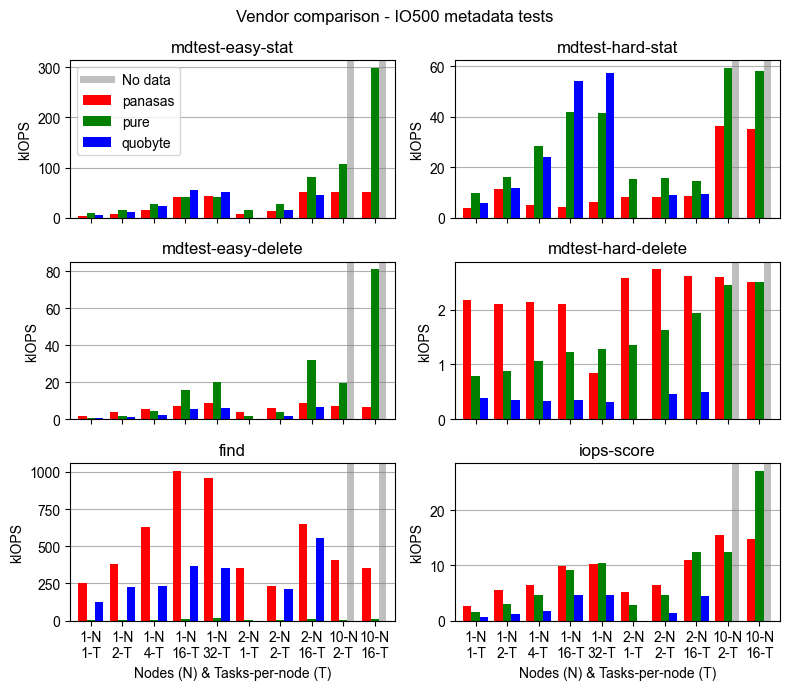

In [9]:
# Code 

def plot_vendor_comparison(
    res_sum, 
    test_name, 
    unit,
    highlight_missing=[],
    missing_lw=10, 
    **kwargs
):
    df = res_sum.reset_index('filesystem.name')
    mask = pd.get_dummies(df['filesystem.name'])
    data = mask.mul(df[test_name], axis=0).groupby(['nodes', 'ntasks_per_node']).max()
    ax = data.plot.bar(color='rgb', width=0.8, zorder=2, **kwargs)
    label_axes(ax, 'pure', unit) #Use 'pure' since it has all node/thread combos
    ax.set_title(test)
    if len(highlight_missing) > 0:
        for i, x in enumerate(highlight_missing):
            ax.axvline(
                [x], 
                lw=missing_lw, 
                c='grey', 
                alpha=0.5, 
                zorder=2, 
                label=('No data' if i == 0 else '')
            )
            if 'legend' not in kwargs:
                ax.legend()
    ax.grid(axis='y')
    
    return ax

tests = [
    'mdtest-easy-stat',
    'mdtest-hard-stat',
    'mdtest-easy-delete',
    'mdtest-hard-delete',
    'find',
    'iops-score'
]

fig, axs = plt.subplots(
    figsize=(8, 7), 
    ncols=2, 
    nrows=len(tests)//2,
    sharex=True
)

for ax, test in zip(axs.flatten(), tests):
    ax = plot_vendor_comparison(
        results_summary, 
        test, 
        'kIOPS',
        ax=ax,
        highlight_missing=[8.22, 9.24],
        missing_lw=5,
        legend=False,
    )
axs[0, 0].legend()
    
fig.suptitle('Vendor comparison - IO500 metadata tests')
fig.tight_layout()
fig.savefig(f'figures/io500-vendor-comparison-metadata.png')